## 1. Exploratory Data Analysis

We are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with. 

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### 1.1. Visualising the data

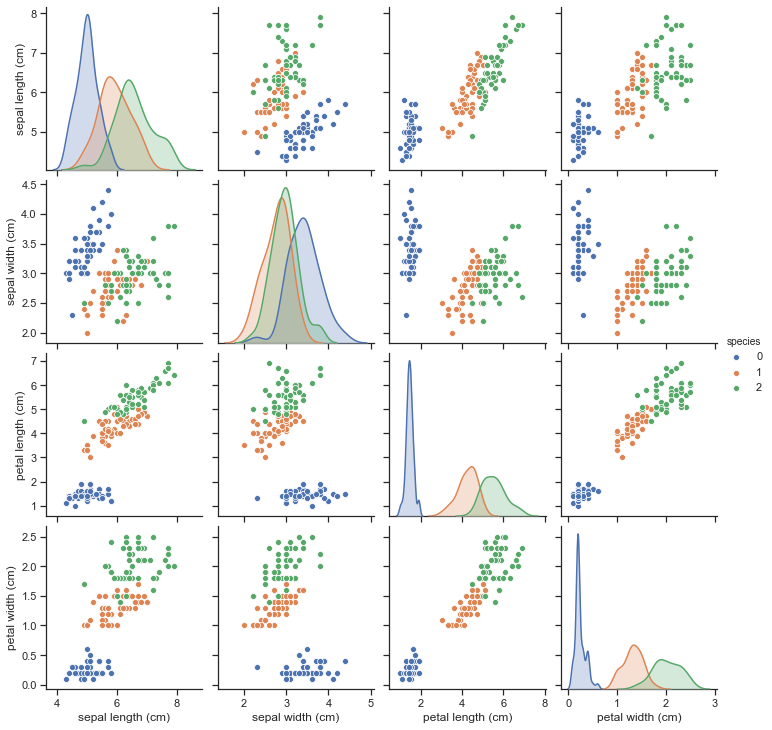

In [2]:
# define plotting function
def myplotGrid(X,y):
    """Pairplot visualization of the training data using the target as hue

    Args:
        X (numpy.ndarray): Training data
        y (numpy.ndarray): Target data
    
    """
   
    data = np.column_stack((X,y))

    df = pd.DataFrame(data, columns=['alcohol','flavanoids','color_intensity','ash', 'class'] )
    df["class"] = df["class"].astype(int)

    sns.pairplot(df, hue="class",palette="Set2")

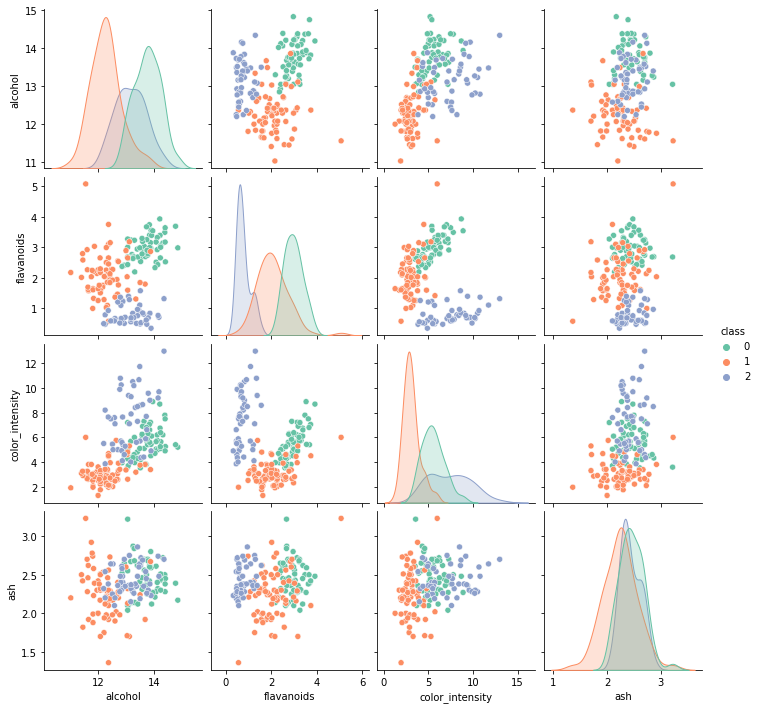

In [3]:
#importing libraries
import seaborn as sns

# run the plotting function
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, I will invoke my exploratory data analysis function above on a noisy version of your data X.

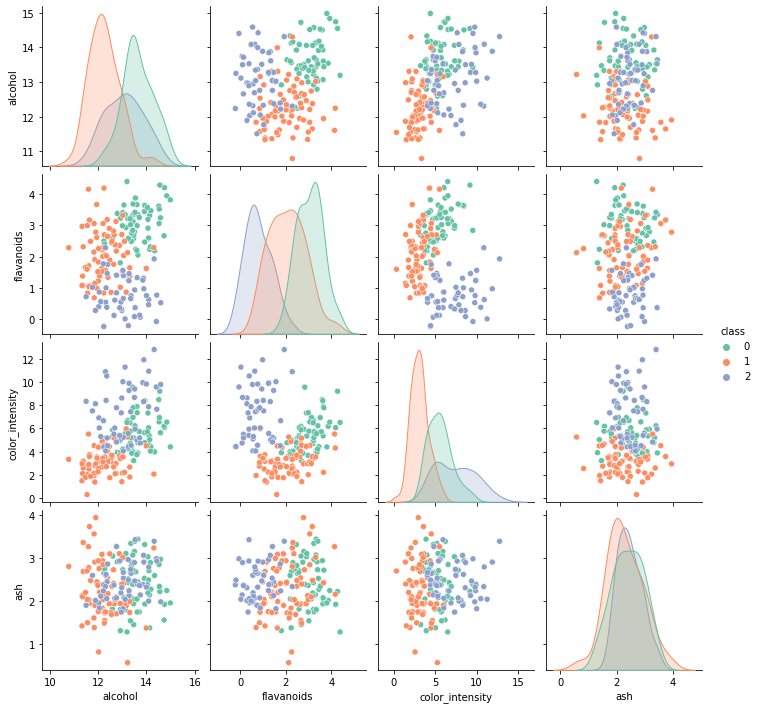

In [4]:
# noise code 
mySeed = 12345 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)

myplotGrid(XN,y)


### Q1. Exploratory data analysis
Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why?  Answer as fully as you can. 


answer:

To build a classifier with the best features possible, we need to look for those features that better represent all the classes in different groups. Let's do a quick analysis of the on the visualized data:

* All features are centered distributed.
* Ash feature looks like the less interesting feature - it is not highly correlated with any other feature and its class distribution overlap between each other - this makes difficult to distinguish any class based on the ash presence, definitely not useful for building a classifier.
* Color Intensity looks a little bit more interesting, it is the most correlated feature - increase of alcohol corresponds in an increment of the colour intensity of the wine and vice versa. Also, class distribution is this time more distinct, even though class 2 is overlapping with the others.
* Flavanoids feature definitely shows high distinctions between the classes in the KDE plot. Even if not highly correlated it is still the most interesting feature up until now to build a classifier, distributions are fairly normally distributed not showing any sign of skewness. 
* Alcohol feature as well shows the best class distribution separation after Flavanoids. It is, as stated before, positively correlated with Color Intensity.

Given this analysis, I think that the best features to build a classifier are Alcohol and Flavanoids.




### Q2. Data with noise
What do you observe by plotting the data without noise compared to plotting with added Gaussian noise? 


answer:



In real world datasets noise is present in a considerable way. Adding noise generally smoots the distribuition curves, it makes them wider and the peaks tend to be less prominet. The scatter plots are less readable in terms of correlations between features and more points tend to overlap, distinguishing between classes become more difficult and less obvious.

## 2. Implementing kNN

In the cell below, I will develop my own code for performing k-Nearest Neighbour classification.


Steps to undertake:

* Create distance functions to evaluate distance between entries (vectors)
* Store the results in a sorted array (ascending sorting)
* Select the k elements of the list where k= # of neighbors
* Evaluate wich class has the maximum number of occurencies
* Assign the class to the data poit to be classified

In [5]:
def get_euclidean_distance(vec_1, vec_2):
    """ 
    This function compute the euclidean distance between two vectors.
    
    Euclidian Distance = sqrt(sum from i to N (vec_1[i]-vec_2[i])^2)

    Args:
        vec_1 (ndarray): Vector - 1D array containing data with "float" type. 
        
        vec_2 (ndarray): Vector - 1D array containing data with "float" type. 

    Returns:
        float: Euclidean distance value
    """
    
    return np.sqrt(sum((vec_1-vec_2)**2))


In [6]:
def get_manhattan_distance (vec_1, vec_2):
    """ 
    This function compute the Manhattan distance between two vectors.
    
    Manhattan Distance = sum from i to N (|vec_1[i]-vec_2[i]|)

    Args:
        vec_1 (ndarray): Vector - 1D array containing data with "float" or "int" type.
        
        vec_2 (ndarray): Vector - 1D array containing data with "float" or "int" type. 

    Returns:
        float: Manhattan distance value
    """
    
    return sum(np.abs(vec_1-vec_2))

In [7]:
def get_nearest_neighbors(train_data, test_row, n_nghb, distance_method):
    """
    This function returns the indexes of the nearest neighbors given the training data and its testing row.

    Args:
        train_data (ndarray): Training Dataset - 2D array containing data with "float" or "int" type
        
        test_row (ndarray): Data entry of the test set - 1D array containing data with "float" or "int" type
        
        n_nghb (int): Number of neighbors
        
        distance_method (str): Type of distance method

    Raises:
        TypeError: raise an error if distance method not spelled correctly

    Returns:
        ndarray: 1D array containing neighbor indexes as "int" type
    """
       
    distances = [] #create an empty list to store distances
    
    #loop trough the entries of the training data to calculate the distance
    for train_row in train_data:
        if distance_method.lower() in ["euclidean", "manhattan"]: #normalizing the text imput to avoid errors
            if distance_method.lower()=="euclidean":
                distance = get_euclidean_distance(test_row, train_row)
                distances.append(distance)
            elif distance_method.lower()=="manhattan":
                distance = get_manhattan_distance(test_row, train_row)
                distances.append(distance)
        else:
            raise TypeError ('Please choose the distance method between : ["Euclidean", "Manhattan"]') 
            
    distances = np.array(distances) #converting "distances" form list to ndarray
    
    n_nghb_indexes = np.argsort(distances)[:n_nghb] # ascending sort of the indexes of the nearest neighbors sorted by distance

    
    return n_nghb_indexes

In [8]:
def get_prediction(train_data, training_label, test_row, n_nghb, distance_method):
    """
    This function returns the predicted training labels given the training data, training labels and the testing row.

    Args:
        train_data (ndarray): Training Dataset - 2D array containing data with "float" or "int" type
        
        training_label (ndarray): Training target - 1D array containing data with "float" or "int" type
        
        test_row (ndarray): Data entry of the test set - 1D array containing data with "float" or "int" type
        
        n_nghb (int): Number of neighbors
        
        distance_method (str): Type of distance method

    Returns:
        int: Predicted label
    """
    
    neighbors = get_nearest_neighbors(train_data, test_row, n_nghb, distance_method) #hetting the index of nearest neighbors
        
    n_closest_classes = training_label[neighbors] # getting the closest vectors given the nearest neighbors
    
    #KNN is based on a majority voting algorithm.
    #In KNN classification, the predicted class label is determined by the voting for the nearest neighbors,
    #that is, the majority class label in the set of the selected k instances is returned. [1]
    #We will find the most commnly occouring label (np.argmax) count how many times it is present in the array (np.bincount)

    predictions = np.argmax(np.bincount(n_closest_classes)) 
    
    return predictions
  
    

In [24]:
# Let's create a function to split the data and test our KNN algorithm

def my_train_test_split(X,y, mySeed, train_size):
    """ 
    This function splits the training data and the labels respectively in 2 parts: one for training and one for testing.

    Args:
        X (ndarray): Training Dataset - 2D array containing data with "float" or "int" type
        
        y (ndarray): Labels vector - 1D array containing data with "int" type
        
        mySeed (int): random seed to enable us to replicate the results
        
        train_size (float): percenatge of training dataset to be splitted

    Returns:
        ndarray: splitted arrays containing train test splits
    """
    
    np.random.seed(mySeed)
    
    shuffle = np.random.permutation(X.shape[0])
    X_shuffled = X[shuffle]
    y_shuffled = y[shuffle]
    
    
    split = int(train_size*X.shape[0]) # splitting the train set

    X_train =X_shuffled[:split,:]
    y_train = y_shuffled[:split]

    X_test = X_shuffled[split:,:]
    y_test = y_shuffled[split:]
    
    return X_train,X_test,y_train, y_test



In [10]:
def myKNN(X,y,X_,n_nghb=1, distance_method="euclidean"):
    """
    This fucntion returns the predictions for the test set given the training data, training labels and the test set.

    Args:
        X (ndarray): Training Dataset - 2D array containing data with "float" or "int" type
        
        y (ndarray): Training labels vector - 1D array containing data with "int" type
        
        X_ (ndarray): Test Dataset - 2D array containing data with "float" or "int" type
        
        n_nghb (int, optional): Number of neighbors. If not specified defaults to 1.
        
        distance_method (str, optional): Distance method. If not specified defaults to "euclidean".

    Returns:
        ndarray: 1D array of predicted labels containing data with "float" or "int" type
    """
    
    predictions = [] #empty list to store predictions
    
    for test_row in X_:
        #appending the outputs to the predictions list
        predictions.append(get_prediction(X,y,test_row, n_nghb, distance_method))
    
    return np.array(predictions)

## 3. Classifier evaluation

In the cell below, I will implement my own classifier evaluation code.

In [11]:
# confusion matrix, accuracy, precision, recall, etc. 


In [12]:
def myConfMat(y_test,y_pred, plt_img=False):
    """
    This function compute a confusion matrix for the predicted labels given the test labels.
    Note that the the notebook must be set "%matplotlib inline" to visualize the heatmap matrix.

    Args:
        y_test (ndarray): Labels vector - 1D array containing data with "float" or "int" type
        
        y_pred (ndarray): Predicted labels vector - 1D array containing data with "float" or "int" type
        
        plt_img (bool, optional): Plot an heatmap as confusion matrix using seabron. Defaults to False.

    Returns:
        (None, ndarray): Either a heatmap visualization of the confusion matrix or a more basic matrix usable for numpy operations.
    """
    
    classno = len(np.unique(y_test)) #extract the number of classes from the labels vector
    
    C=np.zeros((classno,classno)) #create a classno x classno matrix with zeros
    
    label_pairs=list(zip(y_test,y_pred)) #zip together each label pair and make a list
    
    for labels in label_pairs: #build the confusion matrix
        C[labels[0]][labels[1]]+=1
    
    #build a function in case we want to visualize the confusion marix as heatmap
    if plt_img==True:
        
        cfmat = pd.DataFrame((sum(result[1])).astype(int), index = ["class 0", "class 1", "class 2"], columns=["class 0", "class 1", "class 2"]) #creating the confusion matrix dataframe

        ax, fig = plt.subplots(figsize=(6,6))

        ax = sns.heatmap(cfmat,cmap="Greens", annot=True, cbar=False, linewidth=0.5, linecolor="Black", alpha=0.8)

        ax.set_title("Confusion Matrix", weight="bold", fontsize=15)
        ax.set_ylabel("Actual", fontsize=13)
        ax.set_xlabel("Predicted", fontsize=13)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        #set limits to plot the heatmap correctly
        ax.set_xlim([0,3.1])
        ax.set_ylim([3.1,0])


        plt.tight_layout()
        plt.show()
        
        return 
          
    return C

def myAccuracy(y_test,y_pred):
    """
    This function compute the accuracy between the predicted labels and the test labels
    
    Args:
        y_test (ndarray): Labels vector - 1D array containing data with "float" or "int" type
        
        y_pred (ndarray): Predicted labels vector - 1D array containing data with "float" or "int" type

    Returns:
        int: Accuracy
    """
        
    label_pairs = list(zip(y_test,y_pred)) #zip together each label pair and make a list
    
    correct_pred = 0
    
    for labels in label_pairs:
        if labels[0]==labels[1]:
            correct_pred+=1
            
    accuracy=correct_pred/np.shape(y_test)[0]
            
    return accuracy
    

def myPrecision(y_test,y_pred):
    """
    This function compute Precision between the predicted labels and the test labels

    Args:
        y_test (ndarray): Labels vector - 1D array containing data with "float" or "int" type
        
        y_pred (ndarray): Predicted labels vector - 1D array containing data with "float" or "int" type

    Returns:
        ndarray: Precision - 1D array containing data with "float" or "int" type
    """
    
    classes = np.unique(y_test) #creating a variable with the unique classes
    precision = np.zeros(classes.shape) #starting the precision matrix with all zeros
    
    z=0
    for i in myConfMat(y_test,y_pred).T: #filling the precision matrix with values
        precision[z]+=i[z]/sum(i)
        z+=1
        
    return precision


def myRecall(y_test,y_pred):
    """
    This function compute the Recall between the predicted labels and the test labels

    Args:
        y_test (ndarray): Labels vector - 1D array containing data with "float" or "int" type
        
        y_pred (ndarray): Predicted labels vector - 1D array containing data with "float" or "int" type

    Returns:
        ndarray: Recall - 1D array containing data with "float" or "int" type
    """
    classes = np.unique(y_pred) #creating a variable with the unique classes
    recall = np.zeros(classes.shape) #starting the recall matrix with all zeros
    
    z=0
    for i in myConfMat(y_test,y_pred): #filling the recall matrix with values
        recall[z]+=i[z]/sum(i)
        z+=1
    
    return recall

In [13]:
#let's test our KNN function against Sklearn KNN
X_train, X_test, y_train, y_test = my_train_test_split(X, y, mySeed, 0.8) #split the data

y_ = myKNN(X_train,y_train,X_test,10)

for i in list(range(1,11)):
    for d in ["euclidean","manhattan"]:
        prediction = myKNN(X_train,y_train, X_test, i, d)
        print(i,d,myAccuracy(y_test, prediction))

1 euclidean 0.9444444444444444
1 manhattan 0.9722222222222222
2 euclidean 0.9166666666666666
2 manhattan 0.9444444444444444
3 euclidean 0.9722222222222222
3 manhattan 0.9722222222222222
4 euclidean 0.9444444444444444
4 manhattan 0.9722222222222222
5 euclidean 0.9722222222222222
5 manhattan 0.9722222222222222
6 euclidean 0.9722222222222222
6 manhattan 0.9722222222222222
7 euclidean 0.9722222222222222
7 manhattan 0.9722222222222222
8 euclidean 0.9444444444444444
8 manhattan 0.9444444444444444
9 euclidean 0.9444444444444444
9 manhattan 0.9444444444444444
10 euclidean 0.9444444444444444
10 manhattan 0.9444444444444444


In [14]:
#comparing to sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for i in list(range(1,11)):
    for d in ["euclidean","manhattan"]:
        knn = KNeighborsClassifier(n_neighbors=i, metric=d)

        knn.fit(X_train,y_train)

        prediction = knn.predict(X_test)

        print(i,d,accuracy_score(y_test, prediction))


1 euclidean 0.9444444444444444
1 manhattan 0.9722222222222222
2 euclidean 0.9166666666666666
2 manhattan 0.9444444444444444
3 euclidean 0.9722222222222222
3 manhattan 0.9722222222222222
4 euclidean 0.9444444444444444
4 manhattan 0.9722222222222222
5 euclidean 0.9722222222222222
5 manhattan 0.9722222222222222
6 euclidean 0.9722222222222222
6 manhattan 0.9722222222222222
7 euclidean 0.9722222222222222
7 manhattan 0.9722222222222222
8 euclidean 0.9444444444444444
8 manhattan 0.9444444444444444
9 euclidean 0.9444444444444444
9 manhattan 0.9444444444444444
10 euclidean 0.9444444444444444
10 manhattan 0.9444444444444444


In [15]:
#testing evaluation code
print("My Summary \n")
print(f"Classes:      {np.unique(y_)}")
print(f"my confusion matrix: \n{myConfMat(y_test, y_)}")
print(f"my accuracy   {myAccuracy(y_test, y_)}")   
print(f"my precision: {myPrecision(y_test,y_)}")
print(f"my recall:    {myRecall(y_test,y_)}")

My Summary 

Classes:      [0 1 2]
my confusion matrix: 
[[ 9.  0.  0.]
 [ 2. 14.  0.]
 [ 0.  0. 11.]]
my accuracy   0.9444444444444444
my precision: [0.81818182 1.         1.        ]
my recall:    [1.    0.875 1.   ]


In [16]:
#comparing with sklearn

from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Sklearn summary \n")

print(f"Classes:    {np.unique(y_)}")
print(f"confusion matrix: \n{confusion_matrix(y_test, y_)}")
print(f"accuracy   {accuracy_score(y_test, y_)}")   
print(f"precision: {precision_score(y_test,y_, average=None)}")
print(f"recall:    {recall_score(y_test,y_, average=None)}")

Sklearn summary 

Classes:    [0 1 2]
confusion matrix: 
[[ 9  0  0]
 [ 2 14  0]
 [ 0  0 11]]
accuracy   0.9444444444444444
precision: [0.81818182 1.         1.        ]
recall:    [1.    0.875 1.   ]



## 4. Nested Cross-validation using your implementation of KNN

In the cell below, I will develop my own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above.

My cross validation function should be invoked like to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is the data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.


To compute the nested cross validation I will follow this pseudocode [[2]](#references_):

1. Define set of hyperparameters combinations 
2. Divide the data into K folds
3. <b>Outer loop </b> - For each fold $k_{i}$ in K-1 folds:
   1. Set fold $k_{i}$ as the test set
   2. Set all the remaining $i^{th}$ folds as the training set
   3. For each parameter combination
      1. <b>Inner Loop</b> - For each fold $k_{j}$ in K-1 folds:
         1. Set fold $k_{j}$ as the validation set
         2. Train the model on the remaining K-2 folds
         3. Evaluate the model performance on fold $k_{j}$
      2. Calculate the average performance over the K-2 folds for the choosen parameter combination
   4. Train the model on K-1 folds unsing the best parameter combination yielded from the previous point
   5. Evaluate the model performance on fold $k_{i}$
4. Return the performances over the $k_{i^{th}}$ folds and calculate the average performance

In [17]:
def myNestedCrossVal(X,y,outer_foldK, n_nghb, distance_method, mySeed, inner_foldk=2):
    """
    This function compute N-Fold Cross Validation for a data set and its target vector

    Args:
        X (ndarray): Dataset containg the entries for each feature - 2D array containing data with "float" or "int" type
        
        y (ndarray): Target vector containing all the labels - 1D containing data with "int" type
        
        outer_foldK (int): number of outer loops
        
        n_nghb (int): number of neighbors
        
        distance_method (str): Distance method
        
        mySeed (int): random seed to enable us to replicate your results
        
        inner_foldk (int, optional): Number of inner loops per each parameter. Defaults to 2.

    Returns:
        tulpe: tuple with ndarray containing the accuracy and a list of the confusion matrices for each fold
    """
    
    
    accuracy_fold=[] #list to store accuracies folds
    
    # values = []
    best_parameters=[] #list to store the mest paramaters for the final summary
    
    confMat_list = [] #list to store all the confusion matrices per fold
    
    np.random.seed(mySeed) #random seed to enable us to replicate your results
    
    indices=np.random.permutation(range(X.shape[0])) #list of shuffled indices from in the range (0,number of data)
    
    bins=np.array_split(indices, outer_foldK) #split the indices into outer_foldK different bins


    #OUTER LOOP - loop through foldk folds
    for i in range(0,outer_foldK):
        print("-"*10,f"Fold {i+1}", "-"*10)
        print("  distance","ngb"," avg accuracy")
               
        foldTrain=[] # list to save current indices for training
        foldTest=[]  # list to save current indices for testing
        
        foldTest.extend(bins[i]) # taking bin i for testing, rest for training.
        
        for j in range(0, outer_foldK):
            if j != i:
                foldTrain.extend(bins[j])
                
        #setting train test arrays
        X_train, X_test = X[foldTrain], X[foldTest]
        y_train, y_test = y[foldTrain], y[foldTest]
        
        parameters_scores = {} #empty dict to store inner fold scores
        
        #setting the parameter pairs to test in the inner loop
        for distance in distance_method:
            for neighbor in n_nghb:

                train_indices = np.random.permutation(range(X_train.shape[0])) #the train indices are taken from the X_train dataset
                
                train_bins = np.array_split(train_indices, inner_foldk) #split the indices into inner_foldK different bins
                    
                inner_accuracy_fold = [] #list to store inner loop accuracy per parameter set
                
                innerFoldTrain = [] #list to save current indices for inner training
                innerFoldValid = [] #list to save current indices for inner validation
                
                #INNER LOOP - loop through foldk folds
                for iFold in range(0,inner_foldk):
                    
                    # print("inner fold")
                        
                    innerFoldValid.extend(train_bins[iFold]) #taking bin iFold for validation, rest for training.
                    
                    for z in range(0, inner_foldk):
                        if z != iFold:
                            innerFoldTrain.extend(train_bins[j])
                     
                    #setting train validation arrays     
                    inner_X_train, inner_X_valid = X_train[innerFoldTrain], X_train[innerFoldValid]
                    inner_y_train, inner_y_valid = y_train[innerFoldTrain], y_train[innerFoldValid]
                    
                    #making inner prediction using KNN                 
                    inner_y_pred = myKNN(inner_X_train,inner_y_train, inner_X_valid, neighbor, distance)
                    #calculating accuracy
                    inner_accuracy_fold.append(myAccuracy(inner_y_valid, inner_y_pred))
                    
                    
                #evaluate average perfomance for the parameter combination on the inner fold
                parameters_scores[(distance, neighbor)] = np.mean(inner_accuracy_fold)

                print(f"({distance}, {neighbor}, {parameters_scores[(distance, neighbor)]})")           
        
        #assigning best values
        best_n_nghb = max(parameters_scores, key=parameters_scores.get)[1] 
        best_distance_method = max(parameters_scores, key=parameters_scores.get)[0] 
        best_accuracy = parameters_scores[best_distance_method, best_n_nghb]
        
        print(f"\nThe best parameters for Fold {i+1} are: distance {best_distance_method} - neighbors {best_n_nghb} - with avg accuracy over {inner_foldk} inner folds of {best_accuracy} \n")

        #making prediction on the outer loop unsing KNN
        y_pred = myKNN(X_train,y_train, X_test, best_n_nghb, best_distance_method)
        
        print(f"FOLD {i+1} accuracy score on the test set is {myAccuracy(y_test, y_pred)}\n")
        print("Confusion matrix on the testing set: \n", myConfMat(y_test,y_pred), "\n")
        confMat_list.append(myConfMat(y_test,y_pred))
        
        #appending the accuracy obtained on the test set
        accuracy_fold.append(myAccuracy(y_test, y_pred))
        
        #appending the best params to the list to build a dataframe later
        best_parameters.append({
            "Fold" : i+1,
            "Distance" : best_distance_method,
            "n_nghb" : best_n_nghb,
            "avg_accu_inner fold" : best_accuracy,
            "test_set_accu": myAccuracy(y_test, y_pred)
        }) 
        
    #Creating summary dataframe
    summary = pd.DataFrame(best_parameters)
    
    summary.loc["avg", "test_set_accu"] = summary["test_set_accu"].mean()
    summary.loc["std", "test_set_accu"] = summary["test_set_accu"].std()
    summary.fillna("-",inplace=True)
    summary.set_index("Fold", inplace=True)
    
    print("\n Final Summary \n")
    print("Best Inner Fold Parameters: \n", summary, "\n")
        
    return accuracy_fold, confMat_list 

In [18]:
# evaluate clean data code
result = myNestedCrossVal(X,y,5,list(range(1,11)),["euclidean", "manhattan"], mySeed, 5)

---------- Fold 1 ----------
  distance ngb  avg accuracy
(euclidean, 1, 0.8836177322237566)
(euclidean, 2, 0.8666006619494396)
(euclidean, 3, 0.9492762962218789)
(euclidean, 4, 0.9250581727254875)
(euclidean, 5, 0.8977574050218671)
(euclidean, 6, 0.9492762962218789)
(euclidean, 7, 0.9207726415896298)
(euclidean, 8, 0.8665204694875313)
(euclidean, 9, 0.855909265013398)
(euclidean, 10, 0.8824148452951277)
(manhattan, 1, 0.9173243657275607)
(manhattan, 2, 0.9247917958375614)
(manhattan, 3, 0.951887316810159)
(manhattan, 4, 0.9254238043803275)
(manhattan, 5, 0.9432169997715297)
(manhattan, 6, 0.9046539567460051)
(manhattan, 7, 0.9336482973022082)
(manhattan, 8, 0.9103666838465196)
(manhattan, 9, 0.9230982229849787)
(manhattan, 10, 0.8740490297544351)

The best parameters for Fold 1 are: distance manhattan - neighbors 3 - with avg accuracy over 5 inner folds of 0.951887316810159 

FOLD 1 accuracy score on the test set is 0.9722222222222222

Confusion matrix on the testing set: 
 [[12.  0. 

In [19]:
print(f"Accuracy: {(np.mean(result[0])).round(3)} +/-{(np.std(result[0])).round(3)}")

Accuracy: 0.932 +/-0.043


In [20]:
# evaluate noisy data code
result_w_noise=myNestedCrossVal(XN,y,5,list(range(1,11)),["euclidean", "manhattan"], mySeed,5) #evaluate if using inner fold


---------- Fold 1 ----------
  distance ngb  avg accuracy
(euclidean, 1, 0.7283258520721538)
(euclidean, 2, 0.8178980380687308)
(euclidean, 3, 0.8659686534066736)
(euclidean, 4, 0.856522211251159)
(euclidean, 5, 0.8366888736575392)
(euclidean, 6, 0.8622960685085767)
(euclidean, 7, 0.8580105373727192)
(euclidean, 8, 0.818388723992685)
(euclidean, 9, 0.8243039038689147)
(euclidean, 10, 0.8916369784146146)
(manhattan, 1, 0.9161405411039374)
(manhattan, 2, 0.8691926202327146)
(manhattan, 3, 0.9357686319665344)
(manhattan, 4, 0.8841886106096192)
(manhattan, 5, 0.9023474376556614)
(manhattan, 6, 0.8196527410782171)
(manhattan, 7, 0.8222026315095938)
(manhattan, 8, 0.8740490297544351)
(manhattan, 9, 0.896859019591175)
(manhattan, 10, 0.8351394173790757)

The best parameters for Fold 1 are: distance manhattan - neighbors 3 - with avg accuracy over 5 inner folds of 0.9357686319665344 

FOLD 1 accuracy score on the test set is 0.9722222222222222

Confusion matrix on the testing set: 
 [[12.  0. 

In [21]:
print(f"Accuracy: {(np.mean(result_w_noise[0])).round(3)} +/-{(np.std(result_w_noise[0])).round(3)}")

Accuracy: 0.91 +/-0.041


## 5. Summary of results

Using your results from above, fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .972  |  3 | manhattan  |
| 2 | .944  |  5 | euclidean  |
| 3 | .917  |  2 | euclidean |
| 4 | .857  |  9 | euclidean  |
| 5 | .971  |  7 | euclidean  |
| **total** | .932 $\pm$ 0.043 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .972  |  3 | manhattan  |
| 2 | .889  |  5 | euclidean  |
| 3 | .861  |  5 | euclidean  |
| 4 | .886  |  6 | manhattan  |
| 5 | .943  |  4 | manhattan  |
| **total** | .910 $\pm$ 0.041 |   |    |


### 5.2. Confusion matrix summary

Overall results of my nested cross validation evaluation of my K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data).


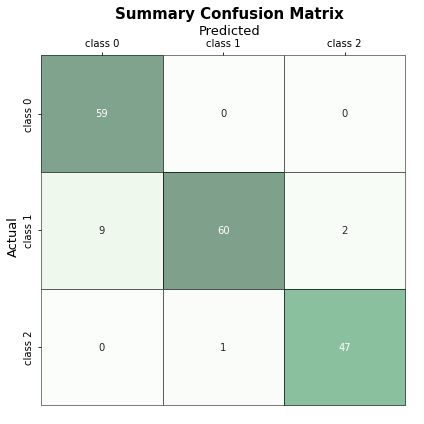

In [22]:
#Plotting the confusion matrix
cfmat = pd.DataFrame((sum(result[1])).astype(int), index = ["class 0", "class 1", "class 2"], columns=["class 0", "class 1", "class 2"])

ax, fig = plt.subplots(figsize=(6,6))

ax = sns.heatmap(cfmat,cmap="Greens", annot=True, cbar=False, linewidth=0.5, linecolor="Black", alpha=0.5)

ax.set_title("Summary Confusion Matrix", weight="bold", fontsize=15)
ax.set_ylabel("Actual", fontsize=13)
ax.set_xlabel("Predicted", fontsize=13)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlim([0,3.1])
ax.set_ylim([3.1,0])

plt.tight_layout()

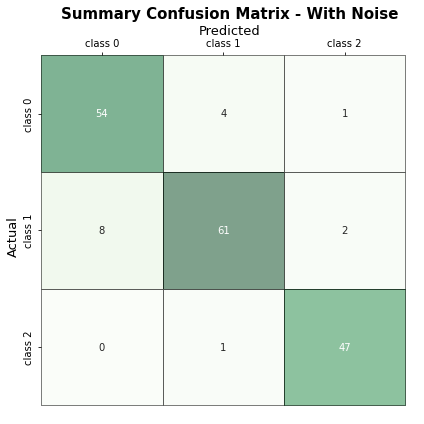

In [23]:
cfmat = pd.DataFrame((sum(result_w_noise[1])).astype(int), index = ["class 0", "class 1", "class 2"], columns=["class 0", "class 1", "class 2"])

ax, fig = plt.subplots(figsize=(6,6))

ax = sns.heatmap(cfmat,cmap="Greens", annot=True, cbar=False, linewidth=0.5, linecolor="Black", alpha=0.5)

ax.set_title("Summary Confusion Matrix - With Noise", weight="bold", fontsize=15)
ax.set_ylabel("Actual", fontsize=13)
ax.set_xlabel("Predicted", fontsize=13)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlim([0,3.1])
ax.set_ylim([3.1,0])

plt.tight_layout()


### Influence of noise
Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used? 


Answer:


Generally speaking we can say that the hyperparameters are highly dependent on the type of data, this implies that each dataset needs its own hyperparameters optimization. This is because adding noise to our data might cause the best parameters to change. With this in mind, we must do some considerations.

1. <b>Choiche of the number of neighors</b>:
* Rarely k=1 is the best choice, and we almost always will obtain better performance using k>1. [[3]](#references_)
* A low value of K leads to overfitting while if it's too high it will over smooth the data losing its capability to define the structure of the dataset. [[3]](#references_)
* For low noise data a low value of K works best and vice versa. [[3]](#references_)
* Typically K fall in 1-20 range. [[3]](#references_)
* Odd values of K are preferred to avoid ties with binary classes. [[3]](#references_)

1. <b>Distance Method</b>:
* Distance method might be highly influenced by the data not being standardized
* Hamming distance is suitable for binary data
* Euclidean distance performs reasonably well on categorical and numerical datasets but it's not suitable for mixed dataset [[4]](#references_)

### Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

Answer:



In case of a tie I would proceed as follows:

1. Define set of hyperparameters combinations 
2. Divide the data into K folds
3. <b>Outer loop </b> - For each fold $k_{i}$ in K-1 folds:
   1. Set fold $k_{i}$ as the test set
   2. Set all the remaining $i^{th}$ folds as the training set
   3. For each parameter combination
      1. <b>Inner Loop</b> - For each fold $k_{j}$ in K-1 folds:
         1. Set fold $k_{j}$ as the validation set
         2. Train the model on the remaining K-2 folds
         3. Evaluate the model performance on fold $k_{j}$
      2. Calculate the average performance over the K-2 folds for the choosen parameter combination
   4. Train the model on K-1 folds unsing the best parameter combination yielded from the previous point
   5. Evaluate the model performance on fold $k_{i}$
4. Evaluate the performances over the $k_{i^{th}}$ folds weighting the neighbors by the distance (eg. $\frac{\alpha}{EuclideanDistance}$) [[5]](#references_)
5. Calculate the average performance



###	Beyond Wine 
If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code. 


Answer:



For KNN is essential to consider standardisation of the data prior to applying the algorithm. This is because in KNN is fundamental the distance between neighbors for the majority voting and in measuring distance between two vectors, features that are measured with comparatively large scale will dominate the measure. Standardization ensure that a variable does not overly influence a model simply due to the scale of its original measurement [[3]](#references_)

<a id='references_'></a>

## References



[1] IBM CORPORATION, , Background of KNN . Available: https://www.ibm.com/docs/en/ias?topic=knn-background [11/12/21] .

[2] Masino, Aaron & Harris, Mary & Forsyth, Daniel & Ostapenko, Svetlana & Srinivasan, Lakshmi & Bonafide, Christopher & Balamuth, Fran & Schmatz, Melissa & Grundmeier, Robert. (2019). Machine learning models for early sepsis recognition in the neonatal intensive care unit using readily available electronic health record data. PLOS ONE. 14. e0212665. 10.1371/journal.pone.0212665. 

[3] BRUCE, B.&.G., 2020. Practical Statistics for Data Scientists. 2 edn. O'Reilly.

[4] Hu, LY., Huang, MW., Ke, SW. et al. The distance function effect on k-nearest neighbor classification for medical datasets. SpringerPlus 5, 1304 (2016). https://doi.org/10.1186/s40064-016-2941-7

[5] ASHOK REDDY, NOVEMBER 5, 2020-last update, K Nearest Neighbors Conceptual Understanding and Implementation in Python. Available: https://www.citrusconsulting.com/k-nearest-neighbors-conceptual-understanding-and-implementation-in-python/ [11/12/21] .